# Case Study 1

#### Predicting Central Neuropathic Pain (CNP) in people with Spinal Cord Injury (SCI) from Electroencephalogram (EEG) data.

* CNP is pain in response to non-painful stimuli, episodic (electric shock), “pins and needles”, numbness
* There is currently no treatment, only prevention
* Preventative medications have strong side-effects
* Predicting whether a patient is likely to develop pain is useful for selective treatment

#### Task
Your task is to devise a feature engineering strategy which, in combination with a classifier of your choice, optizimes prediction accuracy.

#### Data
The data is preprocessed brain EEG data from SCI patients recorded while resting with eyes closed (EC) and eyes opened (EO).
* 48 electrodes recording electrical activity of the brain at 250 Hz 
* 2 classes: subject will / will not develop neuropathic pain within 6 months
* 18 subjects: 10 developed pain and 8 didn’t develop pain
* the data has already undergone some preprocessing
  * Signal denoising and normalization
  * Temporal segmentation
  * Frequency band power estimation
  * Normalization with respect to total band power
  * Features include normalized alpha, beta, theta band power while eyes closed, eyes opened, and taking the ratio of eo/ec.
* the data is provided in a single table ('data.csv') consisting of 
  * 180 rows (18 subjects x 10 repetitions), each containing
  * 432 columns (9 features x 48 electrodes)
  * rows are in subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
  * columns are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
  * feature identifiers for all columns are stored in 'feature_names.csv'
  * 'labels.csv' defines the corresponding class (0 or 1) to each row in data.csv

#### Objective Measure
Leave one subject out cross-validation accuracy, sensitivity and specificity.

#### Report
Report on your feature engineering pipeline, the classifier used to evaluate performance, and the performance as mean and standard deviation of accuracy, sensitivity and specificity across folds. Give evidence for why your strategy is better than others.




# Import Libraries

In [1]:
import warnings
import csv
import numpy as np
import pandas as pd

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 10000)  # or 1000
pd.set_option('display.max_rows', 10000)  # or 1000
pd.set_option('display.max_colwidth', 10000)  # or 199

# Plotting
from matplotlib import pyplot as plt
from IPython.display import display

# Metrics
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, roc_auc_score
from sklearn import metrics

# Model/Feature selection
from sklearn.model_selection import GroupShuffleSplit, LeaveOneGroupOut, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE, SelectFromModel, RFECV, SelectKBest, f_classif, mutual_info_classif, f_regression

# Pipeline
from sklearn.pipeline import make_pipeline, Pipeline

# Classifiers
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Projection
from sklearn.decomposition import PCA
import sklearn.manifold
import umap.umap_ as umap

# Scaling
from sklearn.preprocessing import StandardScaler

# Load data

In [2]:
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv
X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

# Defining Models and Cross Validation Scheme

In [3]:
models = [
          #('LogReg', LogisticRegression()), 
          #('KNN', KNeighborsClassifier()),
          ('SVM', SVC(kernel='linear')), 
        ]
rfecv_models = [
                #('LogReg', LogisticRegression()),
                ('SVM', SVC(kernel='linear'))
               ]
scaler = StandardScaler()
kf = KFold(n_splits=18, shuffle=False)

In [4]:
#Check if model is overfitting:
trains = []
tests = []
#model = KNeighborsClassifier() 
#model = LogisticRegression(C=0.05)
model = SVC(kernel='linear')   
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Applying Scaling
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train, y_train)
    y_p_train = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_p_train)
    y_p_test = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_p_test)
    trains.append(train_acc)
    tests.append(test_acc)
print(np.mean(trains))
print(np.mean(tests))
print(trains)
print(tests)

1.0
0.8999999999999999
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.6, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 1.0, 1.0, 0.9, 1.0, 0.9, 1.0, 0.8, 0.8, 0.9, 0.9]


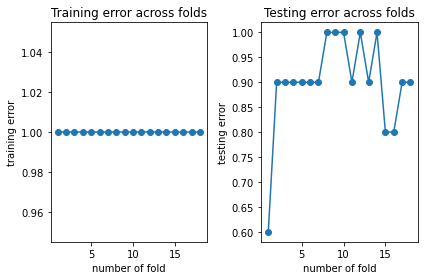

In [5]:
plt.subplot(1,2,1)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(trains).ravel(), 'o-')
plt.xlabel('number of fold')
plt.ylabel('training error')
plt.title('Training error across folds')
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(range(1, kf.get_n_splits() + 1), np.array(tests).ravel(), 'o-')
plt.xlabel('number of fold')
plt.ylabel('testing error')
plt.title('Testing error across folds')
plt.tight_layout()
plt.show()

# Evaluation Functions

In [6]:
def evaluate(models, data, kf):
    results = []
    for name, model in models:
        sensitivity, specificity, accuracy, y_pred, y_true = [], [], [], [], []
        # train loop
        for train_index, test_index in kf.split(data):
            #data = scaler.fit_transform(data)
            X_train, X_test = data[train_index], data[test_index]
            y_train, y_test = y[train_index], y[test_index]
            #Applying Scaling
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            model.fit(X_train, y_train)
            y_model_predict = model.predict(X_test)
            y_pred.extend(y_model_predict)
            y_true.extend(y_test)
            accuracy.append(accuracy_score(y_test, y_model_predict))
        # calculate metrics
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        auc = roc_auc_score(y_true, y_pred)
        sensitivity = tp / (tp + fn)
        specificity = tn / (fp + tn)
        res = {
            "model": name,
            "mean_accuracy": np.mean(accuracy),
            "std_accuracy": np.std(accuracy),
            "sensitivity": sensitivity,
            "specificity": specificity,
            "auc": auc,
        }
        results.append(res)
    return pd.DataFrame.from_dict(results)

In [7]:
def evaluate_model(model, data, kf):
    results = []
    sensitivity, specificity, accuracy, y_pred, y_true = [], [], [], [], []
    # train loop
    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #Applying Scaling
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train, y_train)
        y_model_predict = model.predict(X_test)
        y_pred.extend(y_model_predict)
        y_true.extend(y_test)
        accuracy.append(accuracy_score(y_test, y_model_predict))
    # calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    auc = roc_auc_score(y_true, y_pred)
    sensitivity = tp / (tp + fn)
    specificity = tn / (fp + tn)
    res = {
        "model": name,
        "mean_accuracy": np.mean(accuracy),
        "std_accuracy": np.std(accuracy),
        "sensitivity": sensitivity,
        "specificity": specificity,
        "auc": auc,
    }
    results.append(res)
    return pd.DataFrame.from_dict(results)

In [8]:
def lasso_evaluation(model, X, y, kf, alpha_space):
    results = []
    for alpha in alpha_space:
        model.named_steps['lt'].alpha = alpha
        sensitivity, specificity, accuracy, y_pred, y_true = [], [], [], [], []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            y_model_predict = model.predict(X_test)
            y_pred.extend(y_model_predict)
            y_true.extend(y_test)
            accuracy.append(accuracy_score(y_test, y_model_predict))
        # calculate metrics
        feature_size = model.named_steps['lt'].transform(X_train).shape[1]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        auc = roc_auc_score(y_true, y_pred)
        sensitivity = tp / (tp + fn)
        specificity = tn / (fp + tn)
        res = {
            "model": type(model.steps[2][1]).__name__,
            "accuracy": np.mean(accuracy),
            "std_accuracy": np.std(accuracy),
            "sensitivity": sensitivity,
            "specificity": specificity,
            "auc": auc,
            "feature_size": feature_size
        }
        results.append(res)
    return pd.DataFrame.from_dict(results)

In [9]:
# https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
def corr_df(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if abs(val) >= corr_val:
                # Prints the correlated feature set and the corr val
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        x = x.drop(col, axis=1)
    return x

# Baseline Benchmark with scaling.

In [10]:
results = evaluate(models, X, kf)
results

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.9,0.094281,0.9,0.9,0.9


# Removing highly correlated features

In [87]:
X_corr = corr_df(pd.DataFrame(X), 0.9)
X_corr = X_corr.to_numpy()
X_corr.shape

(180, 256)

# Performance after removing correlated features

In [88]:
results = evaluate(models, X_corr, kf)
results

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.877778,0.135628,0.8625,0.89,0.87625


# Using RFECV to find optimal value of K on Scaled dataset

Optimal number of features : 322


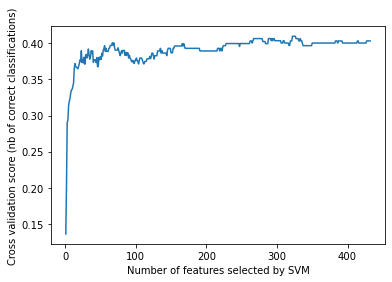

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.916667,0.095743,0.8875,0.94,0.91375


In [84]:
for name, model in rfecv_models:
    rfecv = RFECV(estimator=model, step=1, cv=kf.split(X), scoring='f1', n_jobs=-1)
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    plt.figure()
    plt.xlabel("Number of features selected by " + name)
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    features = rfecv.get_support(indices=True)
    rfecv_data = X[:,features]  
    rfecv_results = evaluate_model(model, rfecv_data, kf)
    display(rfecv_results)

<AxesSubplot:>

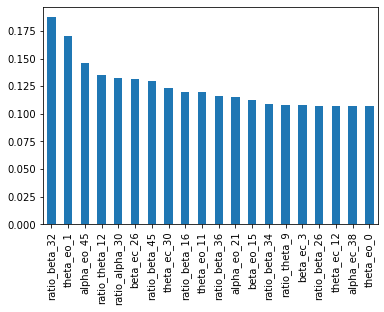

In [85]:
rfecv_feature_names = np.take(np.array(feature_names), features, axis=0)
(pd.Series([a for a in mutual_info.scores_ if a != 0.0][0:rfecv.n_features_], index=rfecv_feature_names)
   .nlargest(20)
   .plot(kind='bar')) 

Optimal number of features : 322


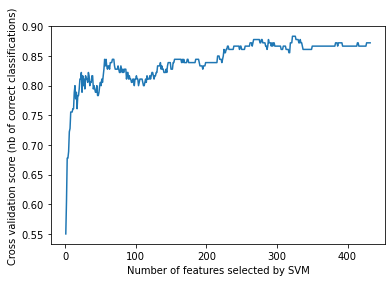

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.916667,0.095743,0.8875,0.94,0.91375


In [75]:
for name, model in rfecv_models:
    rfecv = RFECV(estimator=model, step=1, cv=kf.split(X), scoring='accuracy', n_jobs=-1)
    rfecv.fit(X, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    plt.figure()
    plt.xlabel("Number of features selected by " + name)
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    features = rfecv.get_support(indices=True)
    rfecv_data = X[:,features]  
    rfecv_results = evaluate_model(model, rfecv_data, kf)
    display(rfecv_results)

<AxesSubplot:>

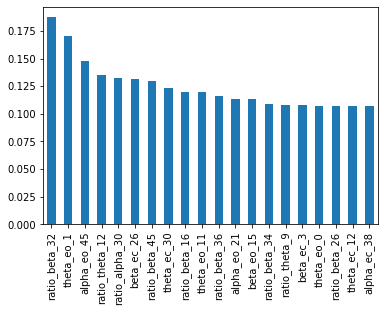

In [76]:
rfecv_feature_names = np.take(np.array(feature_names), features, axis=0)
(pd.Series([a for a in mutual_info.scores_ if a != 0.0][0:rfecv.n_features_], index=rfecv_feature_names)
   .nlargest(20)
   .plot(kind='bar')) 

# RFECV on Correlation dataset.

Optimal number of features : 43


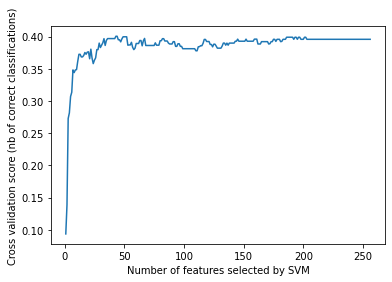

,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.933333,0.094281,0.9375,0.93,0.93375


In [77]:
for name, model in rfecv_models:
    rfecv = RFECV(estimator=model, step=1, cv=kf.split(X_corr), scoring='f1', n_jobs=-1)
    rfecv.fit(X_corr, y)

    print("Optimal number of features : %d" % rfecv.n_features_)

    plt.figure()
    plt.xlabel("Number of features selected by " + name)
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    features = rfecv.get_support(indices=True)
    rfecv_corr_data = X_corr[:,features]  
    rfecv_results = evaluate_model(model, rfecv_corr_data, kf)
    display(rfecv_results)

<AxesSubplot:>

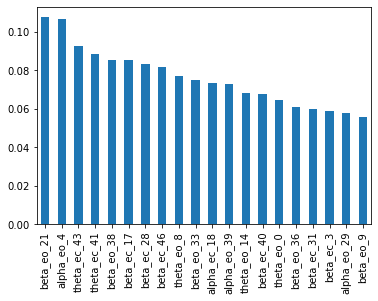

In [78]:
rfecv_feature_names = np.take(np.array(feature_names), features, axis=0)
(pd.Series([a for a in mutual_info.scores_ if a != 0.0][0:rfecv.n_features_], index=rfecv_feature_names)
   .nlargest(20)
   .plot(kind='bar')) 

# ANOVA filter method on scaled dataset.

In [79]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(f_classif, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1, 432)]}, cv=kf.split(X), scoring='accuracy', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    anova = SelectKBest(f_classif, k = best_k_value) 
    anova_data = anova.fit_transform(X, y)
    features = anova.get_support(indices=True)
    anova_data = X[:,features]  
    anova_results = evaluate_model(model, anova_data, kf)
    display(anova_results)

Number of feature selected:  151


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.877778,0.131468,0.85,0.9,0.875


<AxesSubplot:>

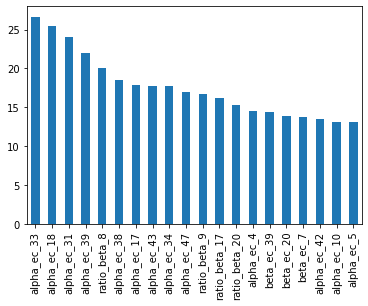

In [80]:
anova_feature_names = np.take(np.array(feature_names), features, axis=0)
(pd.Series([a for a in anova.scores_ if a != 0.0][0:best_k_value], index=anova_feature_names)
   .nlargest(20)
   .plot(kind='bar')) 

In [60]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(f_classif, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1, 432)]}, cv=kf.split(X), scoring='f1', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    anova = SelectKBest(f_classif, k = best_k_value) 
    anova_data = anova.fit_transform(X, y)
    features = anova.get_support(indices=True)
    anova_data = X[:,features]  
    anova_results = evaluate_model(model, anova_data, kf)
    display(anova_results)

Number of feature selected:  149


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.883333,0.134371,0.8625,0.9,0.88125


<AxesSubplot:>

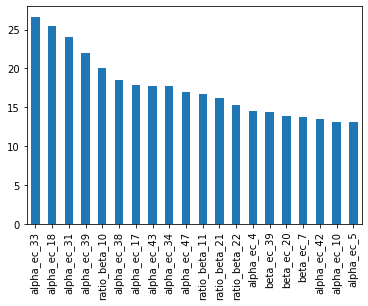

In [62]:
anova_feature_names = np.take(np.array(feature_names), features, axis=0)
(pd.Series([a for a in anova.scores_ if a != 0.0][0:best_k_value], index=anova_feature_names)
   .nlargest(20)
   .plot(kind='bar')) 

['ratio_beta_34' 'ratio_beta_35' 'ratio_beta_37' 'ratio_beta_4'
 'ratio_beta_2' 'ratio_beta_0' 'ratio_beta_29' 'ratio_beta_47'
 'alpha_ec_25' 'ratio_beta_21']
[370 371 373 340 338 336 365 383  25 357  17 343 342  23 374 362 372 366
  31 349 337 369 346 121 344  30 341 377  16  34  26  35 351 122 291 345
 129 350 339 348 358 130 347   4  53  47  39  33 314  10   5  37 265   0
  38 353 322 128 153 378 311 272   3 218  54 361  60 147  59  52  85   1
  83   2   6 379 364 271 258 356   7  36  55  11   9  84 329 137 313 113
 257 375 117 226 131 321 266  15 125 305 363  90 105  61  98  41  12 116
  43 335  91 254 178 288   8  89  99 260  82 293  86  32 126 193  42 110
  87 323 262  58 261  18 270  57 273 143  64  56  22 263  68 418 109 108
  13 114 239 318 140 179  94 146 133  96 214 324 419  48 352 227 280  24
 259 111 132 112  29 192 175 124  69  14 104 170 368 278  95 123 389 304
 269 194  49  97  51 268  27 253 355 185  50 118 248 134 171  80 159 180
  76 359  81 229 279  88 325 144 225 2

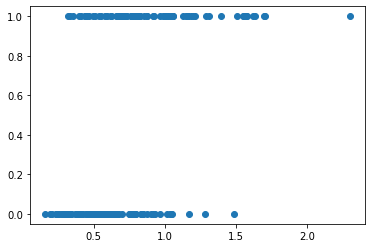

In [103]:
anovascores = anova.scores_
sort_index = np.argsort(-anova_scores)
sorted_anova_scores = anova_scores[sort_index]
feature_names_np = np.array(feature_names)

top_10_scores = sorted_anova_scores[:10]
top_10_feature_names = feature_names_np[sort_index][:10]
top_10_features = X[:,sort_index][:,:10]

print(top_10_feature_names)
print(sort_index)
plt.scatter(top_10_features[:,0], y)

# Mutual Information filter method on scaled dataset.

In [81]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(mutual_info_classif, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1,432,10)]}, cv=kf.split(X), scoring='f1', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    mutual_info = SelectKBest(mutual_info_classif, k=best_k_value)
    mutual_info_data = mutual_info.fit_transform(X, y)
    features = mutual_info.get_support(indices=True)
    mutual_info_data = X[:,features] 
    mutual_info_results = evaluate_model(model, mutual_info_data, kf)
    display(mutual_info_results)

Number of feature selected:  231


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.944444,0.059835,0.9375,0.95,0.94375


<AxesSubplot:>

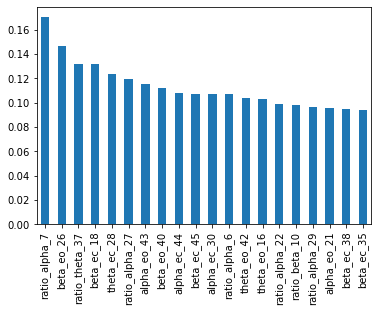

In [82]:
mi_feature_names = np.take(np.array(feature_names), features, axis=0)
(pd.Series([a for a in mutual_info.scores_ if a != 0.0][0:best_k_value], index=mi_feature_names)
   .nlargest(20)
   .plot(kind='bar')) 

In [11]:
for name, model in models:
    clf = Pipeline([('skb', SelectKBest(mutual_info_classif, k = 10)), (name, model)])
    gscv = GridSearchCV(clf, {'skb__k' : [i for i in range(1,432,10)]}, cv=kf.split(X), scoring='accuracy', n_jobs=-1)
    gscv.fit(X, y)
    gscv.best_params_.values()
    best_k_value = [x for x in gscv.best_params_.values()][0]
    print("Number of feature selected: " , best_k_value)
    mutual_info = SelectKBest(mutual_info_classif, k=best_k_value)
    mutual_info_data = mutual_info.fit_transform(X, y)
    features = mutual_info.get_support(indices=True)
    mutual_info_data = X[:,features] 
    mutual_info_results = evaluate_model(model, mutual_info_data, kf)
    display(mutual_info_results)

Number of feature selected:  201


,model,mean_accuracy,std_accuracy,sensitivity,specificity,auc
0,SVM,0.944444,0.068493,0.9375,0.95,0.94375


<AxesSubplot:>

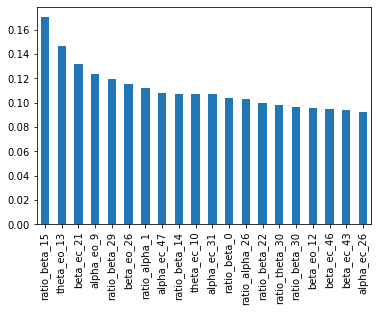

In [14]:
mi_feature_names = np.take(np.array(feature_names), features, axis=0)
(pd.Series([a for a in mutual_info.scores_ if a != 0.0][0:best_k_value], index=mi_feature_names)
   .nlargest(20)
   .plot(kind='bar')) 

[Text(0, 0, 'ratio_beta_5'),
 Text(1, 0, 'beta_eo_18'),
 Text(2, 0, 'alpha_eo_9'),
 Text(3, 0, 'ratio_beta_37'),
 Text(4, 0, 'ratio_alpha_2'),
 Text(5, 0, 'beta_ec_5'),
 Text(6, 0, 'ratio_beta_21'),
 Text(7, 0, 'beta_ec_46'),
 Text(8, 0, 'ratio_alpha_35'),
 Text(9, 0, 'beta_eo_29')]

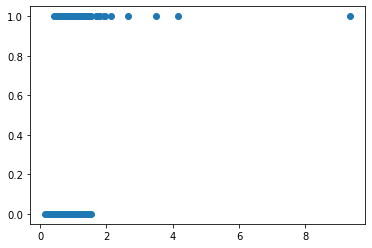

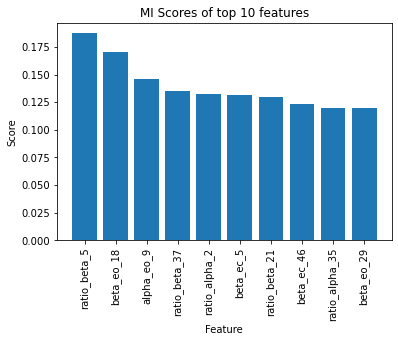

In [15]:
mi_scores = mutual_info.scores_
sort_index = np.argsort(-mi_scores)
sorted_mi_scores = mi_scores[sort_index]
feature_names_np = np.array(feature_names)

top_10_scores = sorted_mi_scores[:10]
top_10_feature_names = feature_names_np[sort_index][:10]
top_10_features = X[:,sort_index][:,:10]
first_feature = top_10_features[:,:1]
ff_wop = np.column_stack((first_feature, y))

plt.scatter(top_10_features[:,0], y)

fig, ax = plt.subplots()
ax.bar(np.arange(10), top_10_scores)
ax.set_title('MI Scores of top 10 features')
ax.set_xlabel('Feature')
ax.set_ylabel('Score')
ax.set_xticks(np.arange(10))
ax.set_xticklabels(top_10_feature_names, rotation='vertical')

In [16]:
sort_index

array([341, 210, 153, 373, 290,  53, 357,  94, 323, 221, 344, 128, 168,
       342, 371,  37, 209, 336,  76,  25, 370, 193, 183, 337, 217, 416,
       242, 222, 338, 117,  69,  66, 322,  23,  59, 218,  21, 374, 372,
       343, 383, 265,  43,   9, 122,  86, 293,  10,  49, 220, 146,  17,
       365, 253,  54, 419, 130, 297, 206,  46, 187, 158,  39,  91, 340,
       165, 104,   3, 315,  31, 129, 327, 227, 219,  92, 105, 263, 179,
        48, 204, 378,  13, 369, 289,  67,  73, 356,  93, 420, 125,  44,
        81, 423, 409,  87, 211,  85, 377,  42, 346, 358,  79, 152, 147,
        89,  84, 116, 414, 350,   6,  30, 230, 329,  11,  51,  83, 389,
       294, 231, 115, 156,  33, 421,  38,   5, 145, 403, 311,  47,  19,
       351,   7, 366,  68, 417, 225,  55, 121,  58, 214, 400, 248,  82,
        16, 157, 106, 300, 359,  20,   0, 208, 287, 159, 354, 213, 212,
         4, 261, 295, 249, 255,  40, 379, 118, 176,  96, 256, 291, 302,
       426, 314, 189,  61, 202, 363, 245,  26, 313, 259, 335,  9

In [17]:
print(feature_names [341])
print(feature_names [210])

ratio_beta_5
beta_eo_18


In [24]:
X[:,341]

array([1.0913 , 1.1547 , 0.54323, 0.41132, 0.66454, 1.1137 , 1.3285 ,
       0.38464, 0.35499, 0.853  , 0.47415, 0.71822, 0.7508 , 0.41872,
       0.47146, 1.5367 , 1.2932 , 0.52254, 0.44531, 0.74805, 0.60229,
       0.5854 , 0.7128 , 0.40803, 1.0119 , 0.73934, 0.38526, 0.37974,
       0.94707, 1.4072 , 0.46452, 0.89818, 0.56348, 0.47749, 0.58339,
       0.66416, 1.1081 , 0.28513, 0.78532, 0.65755, 0.40481, 0.88982,
       0.63366, 0.33903, 0.69417, 0.95259, 1.1095 , 0.67403, 1.0698 ,
       1.023  , 0.61715, 0.89906, 0.79237, 0.50648, 1.1351 , 0.57676,
       0.55599, 0.63014, 0.15802, 0.59636, 0.30992, 1.2715 , 1.2989 ,
       0.26047, 0.45097, 0.92821, 0.69195, 0.51686, 0.1945 , 0.63482,
       0.51464, 0.65734, 0.69396, 0.28213, 0.65052, 1.1521 , 0.69738,
       1.1692 , 0.65853, 0.66116, 0.55379, 0.43267, 0.43443, 0.37961,
       0.64953, 0.61276, 0.4855 , 0.99253, 0.50437, 0.6577 , 0.82942,
       0.59357, 0.99563, 0.38935, 1.4615 , 0.76655, 0.51343, 0.69372,
       0.87735, 0.47

Text(0.5, 1.0, 'Mutual Info')

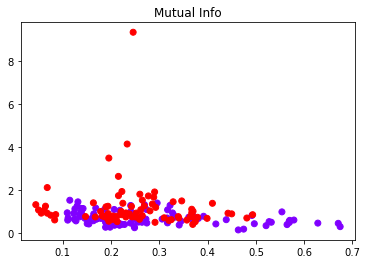

In [25]:
plt.scatter(X[:,210], X[:,341], c=y, cmap='rainbow')
plt.title("Mutual Info")

Text(0.5, 1.0, 'ANOVA')

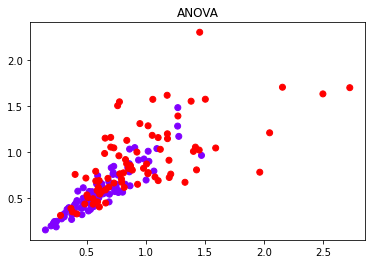

In [26]:
plt.scatter(X[:,371], X[:,370], c=y, cmap='rainbow')
plt.title("ANOVA")

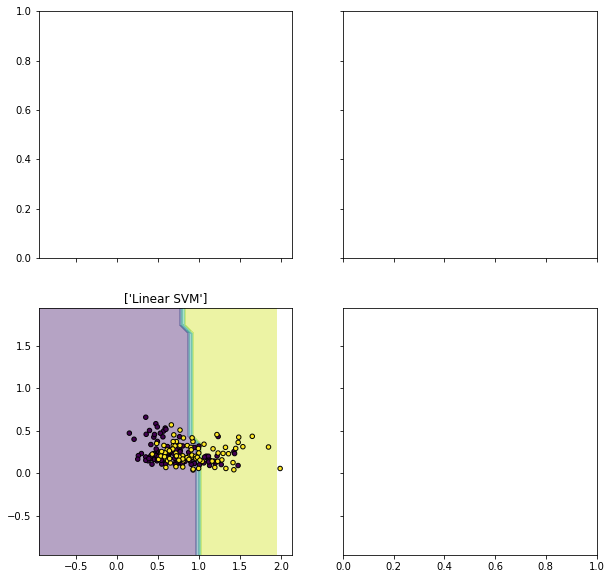

In [138]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets


def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Training classifiers
model = svm.SVC(kernel='linear')
clf = model.fit(X[:, [342, 211]], y)

from itertools import product 

# Plotting decision regions
x_min, x_max = mutual_info_data[:, 0].min() - 1, mutual_info_data[:, 0].max() + 1
y_min, y_max = mutual_info_data[:, 1].min() - 1, mutual_info_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 10))

idx = [1 , 0]
tt = ['Linear SVM']
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
axarr[idx[0], idx[1]].scatter(X[:,342], X[:,211], c=y,
                              s=20, edgecolor='k')
axarr[idx[0], idx[1]].set_title(tt)

plt.show()

In [132]:
mutual_info_data.shape

(180, 231)

# Lasso embedded method feature selection on scaled dataset.

In [ ]:
model = LassoCV(cv=kf.split(X))
model.fit(X, y)

In [61]:
model.alphas_

array([0.8335218 , 0.77734522, 0.72495475, 0.67609523, 0.63052867,
       0.58803315, 0.54840168, 0.51144125, 0.47697182, 0.44482551,
       0.41484576, 0.38688655, 0.36081169, 0.33649419, 0.31381561,
       0.29266548, 0.27294081, 0.25454551, 0.23739   , 0.22139071,
       0.20646971, 0.19255435, 0.17957683, 0.16747395, 0.15618677,
       0.1456603 , 0.13584328, 0.1266879 , 0.11814956, 0.11018668,
       0.10276046, 0.09583475, 0.08937581, 0.08335218, 0.07773452,
       0.07249548, 0.06760952, 0.06305287, 0.05880331, 0.05484017,
       0.05114412, 0.04769718, 0.04448255, 0.04148458, 0.03868865,
       0.03608117, 0.03364942, 0.03138156, 0.02926655, 0.02729408,
       0.02545455, 0.023739  , 0.02213907, 0.02064697, 0.01925543,
       0.01795768, 0.0167474 , 0.01561868, 0.01456603, 0.01358433,
       0.01266879, 0.01181496, 0.01101867, 0.01027605, 0.00958348,
       0.00893758, 0.00833522, 0.00777345, 0.00724955, 0.00676095,
       0.00630529, 0.00588033, 0.00548402, 0.00511441, 0.00476

In [66]:
alpha_space = [0.1456603 , 0.13584328, 0.1266879 , 0.11814956, 0.11018668,
       0.10276046, 0.09583475, 0.08937581, 0.08335218, 0.07773452,
       0.07249548, 0.06760952, 0.06305287, 0.05880331, 0.05484017,
       0.05114412, 0.04769718, 0.04448255, 0.04148458, 0.03868865,
       0.03608117, 0.03364942, 0.03138156, 0.02926655, 0.02729408,
       0.02545455, 0.023739  , 0.02213907, 0.02064697, 0.01925543,
       0.01795768, 0.0167474 , 0.01561868, 0.01456603, 0.01358433,
       0.01266879, 0.01181496, 0.01101867, 0.01027605, 0.00958348,
       0.00893758, 0.00833522, 0.00777345, 0.00724955, 0.00676095,
       0.00630529, 0.00588033, 0.00548402, 0.00511441, 0.00476972,
       0.00444826, 0.00414846, 0.00386887, 0.00360812, 0.00336494,
       0.00313816, 0.00292665, 0.00272941, 0.00254546, 0.0023739 ,
       0.00221391, 0.0020647 , 0.00192554, 0.00179577, 0.00167474,
       0.00156187, 0.0014566 , 0.00135843, 0.00126688, 0.0011815 ,
       0.00110187, 0.0010276 , 0.00095835, 0.00089376, 0.00083352]

In [67]:
from sklearn.base import BaseEstimator, TransformerMixin
class LassoTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, alpha):
        self.alpha = alpha
        pass

    def fit(self, X, y):
        lasso = Lasso(alpha=self.alpha, fit_intercept=False, random_state=0)
        lasso.fit(X, y)
        self.coef_ = lasso.coef_
        self.X_train = X[:,self.coef_!=0]
        return self

    def transform(self, X):
        X_ = X.copy()
        X_ = X_[:,self.coef_!=0]
        return X_

In [68]:
for name, model in models:
    model = Pipeline([('ss', StandardScaler()), ('lt', LassoTransformer(alpha = 0.0)), (name, model)])
    df = lasso_evaluation(model, X, y, kf, alpha_space)
    display(df.iloc[df['auc'].argmax()])

model                 SVC
accuracy         0.933333
std_accuracy    0.0745356
sensitivity        0.9125
specificity          0.95
auc               0.93125
feature_size          153
Name: 74, dtype: object

# Projection Methods for Feature Extraction.

In [25]:
pipe = make_pipeline(StandardScaler(), umap.UMAP(min_dist=0.9,n_components=2), LogisticRegression())

gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'umap__n_components': (1,2,3,4,5,10,20,30,None)
    },
    scoring='accuracy',
    cv=kf.split(X),
    n_jobs = -1
)

grid_result = gsc.fit(X,y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.855556 using {'umap__n_components': 20}


# PCA

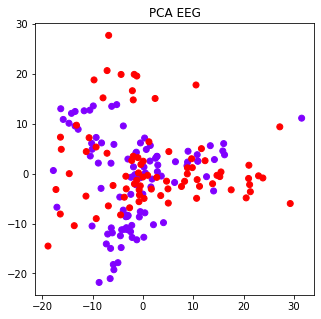

In [26]:
plt.figure(figsize=(5,5))
plt.title("PCA EEG")

# apply principal component analysis
pca = PCA(n_components=2)
pipe = make_pipeline(StandardScaler(), pca)
X_2d = pipe.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')

# TSNE

Text(0.5, 1.0, 'EEG tSNE')

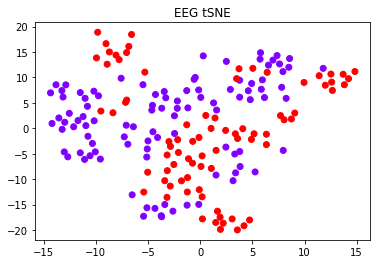

In [27]:
tsne  = sklearn.manifold.TSNE()
pipe = make_pipeline(StandardScaler(), tsne)
X_2d = pipe.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')
plt.title("EEG tSNE")

# UMAP

Text(0.5, 1.0, 'UMAP tSNE')

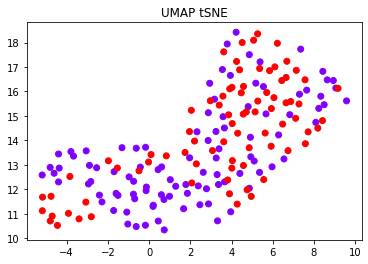

In [28]:
umap  = umap.UMAP(min_dist=0.9,n_components=2)
pipe = make_pipeline(StandardScaler(), umap)
X_2d = umap.fit_transform(X)

# plot each digit with a different color
plt.scatter(X_2d[:,0], X_2d[:,1], c=y, cmap='rainbow')
plt.title("UMAP tSNE")